# Premiers pas avec LangGraph

Objectif de ce notebook :  
- Comprendre ce qu’est un **StateGraph**.  
- Construire un **toy graph** (sans LLM) pour bien voir la mécanique.  
- Puis un **mini agent conversationnel** avec un seul noeud LLM.  
- Visualiser le graphe directement dans le notebook.


## Idée clé : un workflow comme un graphe

Dans LangGraph :

- **State** : l’état partagé qui circule (données, messages, résultats intermédiaires).  
- **Nodes** : des fonctions qui lisent l’état et renvoient un **update** de l’état.  
- **Edges** : les transitions entre noeuds (linéaires ou conditionnelles).  
- **StateGraph** : l’objet qui assemble tout ça et que l’on compile en `graph` exécutable.

Schéma conceptuel :

```text
          +---------+       +---------+       +---------+
  START ->|  Node A | ----> |  Node B | ----> |  Node C |--> END
          +---------+       +---------+       +---------+
               
```

## 🔧 Installation (do once)

Uncomment if needed.

In [ ]:
# !pip install -U langgraph langchain-openai
# For some visualizations (Mermaid PNG):
# !pip install -U grandalf

## 1️⃣ Un premier graphe *sans LLM*

On part d’un exemple très simple :  
- l’état est juste un entier `value`,  
- on applique deux noeuds : `add_one` puis `double`,  
- on voit comment le **StateGraph** fonctionne.

```text
value initial -> [add_one] -> [double] -> value final
```

In [14]:
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class SimpleState(TypedDict):
    value: int

def add_one(state: SimpleState) -> SimpleState:
    print(f"[add_one] state in  = {state}")
    return {"value": state["value"] + 1}

def double(state: SimpleState) -> SimpleState:
    print(f"[double] state in  = {state}")
    return {"value": state["value"] * 2}

builder = StateGraph(SimpleState)
builder.add_node("add_one", add_one)
builder.add_node("double", double)

builder.add_edge(START, "add_one")
builder.add_edge("add_one", "double")
builder.add_edge("double", END)

simple_graph = builder.compile()



- Chaque noeud prend un `state` et renvoie un **fragment** de state.  
- LangGraph s’occupe de **fusionner** les updates et de faire circuler l’état de noeud en noeud.

## 2️⃣ Visualize the graph

LangGraph provides a `get_graph()` method that allows generating:  
- **ASCII** of the graph,  
- **Mermaid** (text),  
- optionally PNG/SVG depending on installed libraries.

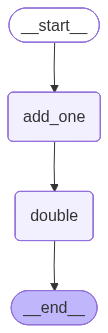

In [ ]:
g = simple_graph.get_graph()

# print("\nMermaid code:")
# print(g.draw_mermaid())

# print("ASCII graph:")
# print(g.draw_ascii())

# If grandalf is installed, we can also generate a PNG directly:
from IPython.display import Image
Image(g.draw_mermaid_png())

In [16]:
result = simple_graph.invoke({"value": 2})
print(f"[END] final state = {result}")

[add_one] state in  = {'value': 2}
[double] state in  = {'value': 3}
[END] final state = {'value': 6}


## 3️⃣ Mini agent conversationnel

On passe maintenant à un **state basé sur des messages**, plus proche d’un vrai agent IA.

On va :  
- utiliser `MessagesState` (state pré-défini dans LangGraph),  
- créer un seul noeud `assistant` qui appelle un LLM via LangChain,  
- connecter `START -> assistant -> END`.

C’est la version la plus minimale d’un agent LangGraph.

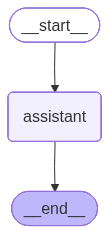

In [ ]:
import os

from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from getpass import getpass

# 1. Define the state
class ChatState(MessagesState):
    """State with a 'messages' key (list of messages)."""
    pass

# 2. Initialize the model
# IMPORTANT: Configure your OpenAI API key in your environment variables
# You can define them via a .env file or by exporting them in your shell:
# export OPENAI_API_KEY="your-key-here"
# Or use getpass to enter it securely:
# os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

# Check that the key is defined
if "OPENAI_API_KEY" not in os.environ:
    raise ValueError("OPENAI_API_KEY must be defined in your environment variables. "
                     "See README.md for configuration instructions.")

chat_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

# 3. Define the main node
def assistant_node(state: ChatState) -> ChatState:
    """
    Reads messages in the state, calls the LLM,
    returns an update with the new AI message.
    """

    # Here we call the LLM without adding a custom prompt, we could do it.
    response = chat_model.invoke(state["messages"])
    return {"messages": [response]}

# 4. Build the graph
builder = StateGraph(ChatState)
builder.add_node("assistant", assistant_node)
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

chat_graph = builder.compile()
g = chat_graph.get_graph()
Image(g.draw_mermaid_png())


In [ ]:
# 5. Run a query
initial_state: ChatState = {
    "messages": [HumanMessage(content="Explain in 3 sentences what LangGraph is and how it complements LangChain.")]
}

result_state = chat_graph.invoke(initial_state)
for m in result_state["messages"]:
    print(f"{m.type.upper()}: {m.content}\n")

HUMAN: Explique en 3 phrases ce qu'est LangGraph et en quoi il complète LangChain.

AI: LangGraph est une bibliothèque qui permet de créer et de manipuler des graphes de connaissances en intégrant des modèles de langage. Elle complète LangChain en offrant une structure pour organiser et interroger des informations de manière plus complexe, facilitant ainsi la gestion des relations entre les données. Ensemble, LangGraph et LangChain permettent de construire des applications plus intelligentes et interactives en combinant la puissance des modèles de langage avec des graphes de connaissances.



## CCL : Rôle de ce notebook 

- Le notebook LangChain montre comment **construire un agent individuel / une chaîne**.  
- Ce notebook LangGraph montre comment **orchestrer** des étapes en graphe.  
- Le dernier notebook (météo + calendrier) illustrera ensuite un **pattern d’agent plus riche** avec plusieurs tools et une logique réelle.

